### Spam classification

### 1. Setup

Install required text processing libraries for the example

In [4]:
#pip3 install nltk

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jpachas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jpachas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jpachas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Creating Text Representations

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

#Load Spam Data and review content
spam_data = pd.read_csv("spam_classification.csv")

print("\nLoaded Data :\n------------------------------------")
print(spam_data.head())

#Separate feature and target data
spam_classes_raw = spam_data["CLASS"]
spam_messages = spam_data["SMS"]



Loaded Data :
------------------------------------
  CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


In [7]:
import nltk
import tensorflow as tf

#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)

#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(
                                spam_classes_raw)

#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)

TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


### 5.3. Building and Evaluating the Model

In [9]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

#Setup Hyper Parameters for building the model
NB_CLASSES=2
N_HIDDEN=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(X_train.shape[1],),
                              name='hidden_layer_1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='hidden_layer_2',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='output_layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                146144    
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,266
Trainable params: 147,266
Non-trainable params: 0
_________________________________________________________________



Training Progress:
------------------------------------
Epoch 1/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1849 - accuracy: 0.9935 - val_loss: 0.2635 - val_accuracy: 0.9630
Epoch 2/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1554 - accuracy: 0.9954 - val_loss: 0.2395 - val_accuracy: 0.9593
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1302 - accuracy: 0.9963 - val_loss: 0.2180 - val_accuracy: 0.9630
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1086 - accuracy: 0.9963 - val_loss: 0.2006 - val_accuracy: 0.9630
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0905 - accuracy: 0.9963 - val_loss: 0.1841 - val_accuracy: 0.9667
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0750 - accuracy: 0.9972 - val_loss: 0.1713 - val_accuracy: 0.9667
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624 - accuracy: 0.9972 - val_loss: 0.1617

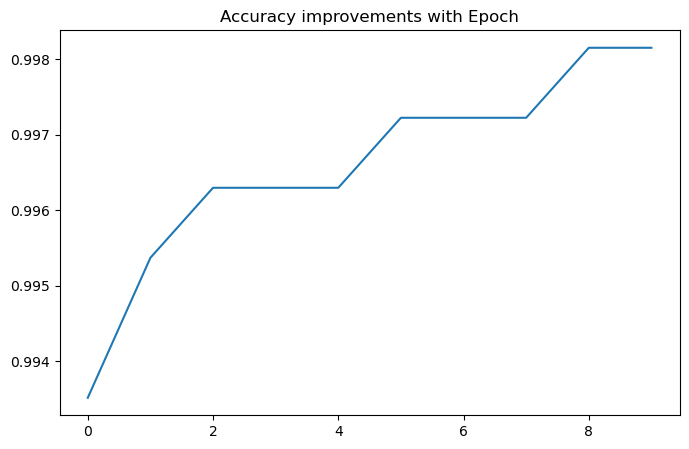


Evaluation against Test Dataset :
------------------------------------
5/5 [==============================] - 0s 1ms/step - loss: 0.1381 - accuracy: 0.9600


[0.1381330043077469, 0.9599999785423279]

In [11]:
#Make it verbose to see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

### 4. Predicting for Text

In [12]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest",
                                    "Yup I will come over"]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax(model.predict(predict_tfidf), axis=1)
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4566)
1/1 [==============================] - 0s 49ms/step
Prediction Output: [1 0]
Prediction Classes are  ['spam' 'ham']
